In [1]:
import sys 
sys.path.append("../")

import pandas as pd
import numpy as np
from IPython.display import display

#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.layers import Dense, CuDNNLSTM, Activation, Dropout
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS, TSNE

from pgtaa.config import *
from pgtaa.core.utils import *

In [ ]:
data_gen = TimeseriesGenerator(data, targets,
                               length=10, sampling_rate=2,
                               batch_size=2)

In [2]:
df = pd.read_csv(TRAIN_CSV, index_col=0, parse_dates=True)
df.iloc[:, :8] = df.iloc[:,:8].pct_change(1)
df.dropna(inplace=True)
df.head(3)

,iShares Russell 1000 Value ETF (IWD),iShares Russell 1000 Growth ETF (IWF),iShares Russell 2000 Growth ETF (IWO),iShares Russell 2000 Value ETF (IWN),iShares MSCI EAFE ETF (EFA),iShares TIPS Bond ETF (TIP),SPDR Gold Trust (GLD),Vanguard REIT ETF (VNQ),USD/EUR,CNY/USD,...,Civilian Unemployment Ratet,Consumer Price Index for All Urban Consumers: All Items,Industrial Production Index,Federal Debt: Total Public Debt as Percent of Gross Domestic Product,Personal Consumption Expenditures,Effective Federal Funds Rate,Primary Credit Rate,Interest Rates Discount Rate for United States,10-Year Treasury Constant Maturity Rate,All Employees: Total Nonfarm Payrolls
2005-01-10,0.004013,0.006250,0.009982,0.010000,0.004509,0.000668,0.002629,-0.003177,1.3109,8.2765,...,5.327273,191.818182,98.971655,60.919206,8536.6602,2.34,3.25,3.318182,4.29,132864.545455
2005-01-11,-0.006302,-0.006832,-0.011296,-0.009085,-0.001923,0.000953,0.006198,-0.010124,1.3161,8.2765,...,5.331818,191.854545,99.001864,60.915506,8538.9444,2.35,3.25,3.329545,4.26,132875.636364
2005-01-12,0.002320,0.004378,0.001428,0.001921,0.008031,0.003523,0.009240,-0.004734,1.3281,8.2765,...,5.336364,191.890909,99.032073,60.911805,8541.2286,2.36,3.25,3.340909,4.25,132886.727273


In [3]:
train = StandardScaler().fit_transform(df.values)

In [4]:
pca = PCA(n_components=1)
pcc = pca.fit_transform(np.cov(train[:,:8].T))
pcc

array([[-0.70890834],
       [-0.69316197],
       [-0.66428075],
       [-0.69967173],
       [-0.54147367],
       [ 2.2091984 ],
       [ 1.53419518],
       [-0.43589713]])

In [5]:
t = df.iloc[:,:8]

In [12]:
import pandas as pd
import numpy as np
from pgtaa.core.optimize import WeightOptimize


class Env:
    def __init__(self, data: np.ndarray, seed: int):
        """
        Base class for environment objects. Most of it's methods have to be overridden in the subclasses.
        
        Arguments:
            init_portfolio_value {np.ndarray} -- historical data
            seed {int} -- number for random seed
        """
        self.data = data
        np.random.seed(seed)
        
    def observation(self):
        NotImplementedError
        
    def step(self, action: np.ndarray):
        #reward, info = self._step(action)
        #return reward, info
        return self._step(action)
    
    def reset(self):
        return self._reset()
    
    def _step(self, action):
        NotImplementedError
    
    def _reset(self):
        NotImplementedError
        
    def __str__(self):
        return str(self.__class__.__name__)
    
    def __len__(self):
        return len(self.data)
    
    @property
    def action_space(self):
        NotImplementedError
    
    @property
    def state_space(self):
        NotImplementedError
        

class PortfolioEnv(Env):
    def __init__(
        self, 
        data: np.ndarray,
        nb_assets: int = 8,
        episodes: int = 100,
        epochs: int = 1,
        horizon: int = 30,
        window_size: int = 100,
        portfolio_value: float = 1000.,
        risk_aversion: float = 1.,
        costs: float = 0.025,
        seed: int = 42
    ):
        """
        Main environment for portfolio management. RL agents are being trained on this environment. 
        
        Arguments:
            data {np.ndarray} -- train or test set of historical data
        
        Keyword Arguments:
            nb_assets {int} -- number of assets in the portfolio (default: {8})
            horizon {int} -- investment horizon (default: {20})
            episodes {int} -- number of training/testing episodes (default: {100})
            epochs {int} -- number of training epochs (default: {1})
            window_size {int} -- evaluation window (number of previous days + current day) (default: {100})
            epochs {int} -- number of training epochs, if testing epochs=1 (default: {1})
            risk_aversion {float} -- rate of risk aversion (default: {1.0})
            costs {float} -- rate of composure to risk (default: {0.0025})
            seed {int} -- number for random seed setting (default: {42})
            val_eps {int} -- number of validation episodes, if testing val_eps=None (default: {None})
            predictors {list} -- list of market/asset price predictors (default: {None})
        """
        super(PortfolioEnv, self).__init__(data, seed)
        self.nb_assets = nb_assets
        # self.horizon = horizon
        # self.window_size = window_size
        #self.portfolio_value = portfolio_value
        # self.risk_aversion = risk_aversion
        #self.costs = costs
        
        # initialization of helper classes like portfolio init class, portfolio tracker class
        # and a dataloader class
        self.pinit = PortfolioInit(data, nb_assets, horizon, episodes, 
                                   window_size, epochs, risk_aversion)

        self.dl = DataLoader(data, nb_assets, episodes, 
                             horizon, window_size)
        
        self.portfolio = Portfolio(portfolio_value, risk_aversion, costs)
        
    def observation(self):
        weights, var_covar, returns, mean, areturn = ()
        
    @classmethod
    def from_config_spec(cls, data, train_mode=True):
        """
        Reads the config.py specs and initializes the PortfolioEnv based on this file. 
        
        Arguments:
            data {np.ndarray} -- train or test set of historical data
        
        Keyword Arguments:
            train_mode {bool} -- evaluation or training mode (default: {True})

        Returns:
            PortfolioEnv -- initializes PortfolioEnv
        """
        import pgtaa.config as cfg  
        if train_mode:
            episodes = cfg.TRAIN_EPISODES
            epochs = cfg.EPOCHS
        else:
            episodes = cfg.TEST_EPISODES
            epochs = 1
        
        return cls(data, cfg.NB_ASSETS, episodes, epochs, cfg.HORIZON, cfg.WINDOW_SIZE, 
                   cfg.PORTFOLIO_INIT_VALUE, cfg.RISK_AVERSION, cfg.COSTS, cfg.SEED)
        
    @property
    def action_space(self):
        # return action space shape
        return self.nb_assets,
    
    @property
    def state_space(self):
        # return state space shape
        return int(0.5 * self.nb_assets * (self.nb_assets + 7)),
    
    
class DataLoader:
    def __init__(self, 
                 data: np.ndarray, 
                 nb_assets: int, 
                 episodes: int,
                 horizon: int, 
                 window_size: int
                ):
        """
        DataLoader for the PortfolioEnv.  
        
        Arguments:
            data {np.ndarray} -- train or test set of historical data
        
        Keyword Arguments:
            nb_assets {int} -- number of assets in the portfolio (default: {8})
            episodes {int} -- number of training/testing episodes (default: {100})
            horizon {int} -- investment horizon (default: {20})
            window_size {int} -- evaluation window (number of previous days + current day) (default: {100})
        """
        self.data = data
        self.horizon = horizon
        self.nb_assets =nb_assets
        self.episodes = episodes
        self.window_size = window_size
        
    def init_batches(self):
        pass
        
    def get_batch(self):
        print(self.episodes)

        
class PortfolioInit(object):
    def __init__(self,
                 data: np.ndarray,
                 nb_assets: int,
                 horizon: int,
                 episodes: int,
                 window_size: int,
                 epochs: int = 1,
                 risk_aversion: float=1.0,
                 val_eps: int=None,
                 predictors: list=None
                 ):
        """
        Initializes the portfolio by calculating episode windows. Those windows contain
        historical data windows for each timestep (evaluation window with a fixed size + 
        current timestep), initial episode start asset weights as well as predictions for each timestep 
        
        Arguments:
            data {np.ndarray} -- train or test set of historical data
            nb_assets {int} -- number of assets in the portfolio
            horizon {int} -- investment horizon
            episodes {int} -- number of training/testing episodes
            window_size {int} -- evaluation window (number of previous days + current day)
        
        Keyword Arguments:
            epochs {int} -- number of training epochs, if testing epochs=1 (default: {1})
            risk_aversion {float} -- rate of risk aversion (default: {1.0})
            val_eps {int} -- number of validation episodes, if testing val_eps=None (default: {None})
            predictors {list} -- list of market/asset price predictors (default: {None})
        """

        self.data = data
        self.assets = data[:, :8]
        self.episodes = episodes
        self.epochs = epochs
        self.horizon = horizon
        self.window_size = window_size
        self.nb_assets = nb_assets
        self.risk_aversion = risk_aversion
        self.predictors = predictors

        # random permutation of episode starting point
        episode_starts = np.random.permutation(range(self.window_size, len(data) - self.horizon))
        self.episode_starts = episode_starts[:episodes]
        self.windows, self.init_weights, self.preds = self._get_windows(*self._build_windows())
        # np.save("window", self.windows)
        # np.save("weights", self.init_weights)
        # np.save("preds", self.preds)

        #self.val_window = self.episode_window[self.episodes:]
        #self.episode_window = self.episode_window[:self.episodes]
        
        print("Portfolio environment has been initialized.")

    def _get_windows(self, window: np.ndarray, weights: np.ndarray, pred: np.ndarray):
        """Given multiple training epochs, for each epoch the sequence of episodes will be randomly shuffeled
        to (hopefully) improve agent training.
        
        Arguments:
            window {np.ndarray} -- data window for each episode
            weights {np.ndarray} -- inital weights for each episode
            pred {np.ndarray} -- prediction for each episode and each timestep
        
        Returns:
            tuple -- multiple arrays where epoch has been added as a new dimension
        """

        epoch_permutations = [np.random.permutation(self.episodes) for _ in range(self.epochs)]
        windows = []
        init_weights = []
        preds = []
        for i in range(self.epochs):
            windows.append(window[epoch_permutations[i]])
            init_weights.append(weights[epoch_permutations[i]])
            #preds.append(pred[epoch_permutations[i]])
        
        # windows has the shape (epochs, nb_epsides, horizon, window_size, columns)     5D
        # init_weights has the shape (epochs, nb_episodes, columns)                     3D
        # preds has the shape (epochs, nb_episodes, horizon, predictors, columns)       4D
        return np.array(windows), np.array(init_weights), np.array(preds)

    def _build_windows(self):
        """Creates episode windows containing historical data as well market predictions 
        for each episode and each timestep. Furthermore ptimized initial weights for each 
        episode will be calculated.
        
        Returns:
            tuple -- multiple arrays
        """

        # each window has horizon times subwindows
        w_episodes = []
        init_weights = []
        predictions = []
        for episode in self.episode_starts:
            ws = []
            prd = []
            assets = self.assets[episode - self.window_size: episode]
            weight = WeightOptimize(assets, np.cov(assets.T), self.risk_aversion).optimize_weights()
            for s in range(self.horizon):
                w = self.data[episode - self.window_size + s : episode + s]
                ws.append(w)
                # TODO: Add model predictions
                #prd.append([predictor.predict(w) for predictor in self.predictors])
            # prediction.append(prd)
            w_episodes.append(ws)
            init_weights.append(weight)
        
        # w_episodes has the shape (nb_epsides, horizon, window_size, columns)      4D
        # init_weights has the shape (nb_episodes, columns)                         2D
        # predictions has the shape (nb_episodes, horizon, num_predictors, columns) 3D
        return np.array(w_episodes), np.array(init_weights), np.array(predictions)   
    
    
class Portfolio:

    def __init__(
            self,
            init_portfolio_value: float=100.0,
            risk_aversion: float=1.0,
            costs: float=0.025
    ):
        """
        Provides some useful utility for basic portfolio calculations.
        Keeps track of portfolio development (like variance, return, sharpe ratio etc.).
        Has to be called for each new episode.
        
        Keyword Arguments:
            init_portfolio_value {float} -- initial portfolio value (default: {100.0})
            risk_aversion {float} -- rate of risk aversion (default: {1.0})
            costs {float} -- transaction costs as a percentage of total transaction volume (default: {0.025})
        """

        self.init_portfolio_value = init_portfolio_value
        self.portfolio_value = init_portfolio_value
        self.costs = costs
        self.risk_aversion = risk_aversion
        self.weights = []
        self.new_weights = []
        self.covariance = []
        self.portfolio_return = 0.
        self.cost = 0.
        self.variance = 0.
        self.sharpe = 0.

    def __str__(self):
        return str(self.__class__.__name__)

    def update(self, actions: np.ndarray):
        """Updates the environment based on agent action and returns the next state observation 
        to the agent.
        
        Arguments:
            actions {np.ndarray} -- agent actions for each asset
        
        Returns:
            [type] -- [description]
        """

        # update portfolio weights based on given actions
        self.new_weights = actions

        # calculate weight difference
        _weight_diff = self.new_weights - self.weights

        # estimate costs for trading
        self.cost = self._get_cost(_weight_diff)

        # update portfolio value
        self.portfolio_value -= self.cost

        return self.new_weights, self.cost, self.portfolio_value

    def step(self, asset_returns: np.ndarray, covariance: np.ndarray):
        """Make a step in time and return the resulting reward asset returns and asset weights.

        Arguments:
            asset_returns {np.ndarray} -- asset returns price_t / price_{t-1} - 1
            covariance {np.ndarray} -- variance-covariance matrix based on current window
        
        Returns:
            tuple -- reward, weights, portfolio value
        """
        # step forward and get new window
        self.covariance = covariance

        # get new weights
        self.weights = self._get_weights(asset_returns)

        # calculate portfolio return
        self.portfolio_return = np.dot(self.new_weights, asset_returns)

        # calculate new portfolio variance based on updated window
        self.variance = self._get_variance()

        # get reward based on reward function
        step_reward = self._get_reward()

        # update portfolio value
        self.portfolio_value *= (self.portfolio_return + 1)

        # calculate sharpe ratio
        self.sharpe = self._sharpe_ratio()

        return step_reward, self.weights, self.portfolio_value

    def reset(self, weights: np.ndarray, covariance: np.ndarray):
        """Resets the portfolio value and the asset weights to their initial value.
        
        Arguments:
            weights {np.ndarray} -- current asset weights
            covariance {np.ndarray} -- variance-covariance matrix
        """
  
        self.portfolio_value = self.init_portfolio_value
        self.weights = weights
        self.covariance = covariance
        self.variance = self._get_variance()
        self.sharpe = self._sharpe_ratio()

    def _get_weights(self, asset_returns: np.ndarray):
        """Natural change of portfolio weights given possible deviations in asset returns.
        
        Arguments:
            asset_returns {np.ndarray} -- linear returns for each asset 
        
        Returns:
            np.ndarray -- weights for the next timestep
        """
        return asset_returns * self.new_weights / np.sum(asset_returns * self.new_weights)

    def _get_cost(self, weight_diff: np.ndarray):
        """Cost for trading based on total trading volume in relation to the portfolio value.
        
        Arguments:
            weight_diff {np.ndarray} -- difference between old asset weights and reallocated weights
        
        Returns:
            float -- transaction cost based on transaction volume and portfolio value
        """

        # cost for trading based on trading volume
        cost = 0
        sum_weight_diff = sum(abs(weight_diff))     # sum over absolute weight difference
        if round(sum_weight_diff, 5) != 0:
            cost += sum_weight_diff * self.portfolio_value * self.costs
        return cost

    def _get_reward(self):
        # returns the perceived reward (utility) of the portfolio.
        return self.portfolio_return - self.risk_aversion / 2 * self.variance - \
               self.cost / self.portfolio_value

    def _sharpe_ratio(self, risk_free=0.):
        """Reward-to-Variability-Ratio (Sharpe Ratio).
        Keyword Arguments:
            risk_free {float} -- risk free rate, assumed to be zero because of very small investment horizons (default: {0.0})
        
        Returns:
            float -- sharpe ration
        """
        return (self.portfolio_value / self.init_portfolio_value - 1 - risk_free) \
                / np.sqrt(self.variance)

    def _get_variance(self):
        # returns the portfolio variance
        return self.weights @ self.covariance @ self.weights


In [13]:
data = read_data(TRAIN_CSV)
p = PortfolioEnv.from_config_spec(data)

The size of the state space can be calculated by $\frac{1}{2}n(n+7)$.

In [16]:
from sys import getsizeof
getsizeof(p.pinit.windows)

30720000160

In [18]:
p.__sizeof__() # 

32

In [20]:
print("Epochs: {}, Episodes: {}, Horizon: {}, Window Size: {}, Columns: {}".format(*p.pinit.windows.shape))

Epochs: 200, Episodes: 200, Horizon: 30, Window Size: 100, Columns: 32


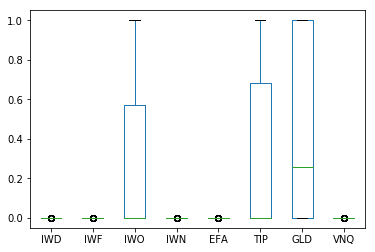

In [37]:
pd.DataFrame(p.pinit.init_weights[0], columns=ASSETS).plot(kind="box")

In [39]:
p.pinit.init_weights[0][7]

array([0.00000000e+00, 0.00000000e+00, 5.27332218e-12, 1.18960544e-12,
       0.00000000e+00, 7.78213121e-01, 2.21786879e-01, 0.00000000e+00])